## Install Requirements

In [1]:
import numpy as np
import ndjson
import os
import matplotlib.pyplot as plt
import itertools
import math

## Import Data using ndjson

In [2]:
data_dir = os.path.join("../data/")

In [3]:
def load_data(data_dir):
    data_fnames = os.listdir(data_dir)
    A = [0 for i in range(len(data_fnames))]
    
    for i, fname in enumerate(data_fnames):

        # Get filepath
        full_path = os.path.join(data_dir, fname)

        # Load file
        with open(full_path, "rb") as f:
            A[i] = ndjson.load(f)
            f.close()
    return A

## Visualize Strokes
We'll use matplotlib to visualize series of strokes.

In [4]:
def display_strokes(drawing):
    sqrt_N = math.ceil(np.sqrt(len(drawing)))
    fig, axs = plt.subplots(sqrt_N, sqrt_N, sharex=True, sharey=True)
    xplot_index = 0
    yplot_index = 0
    xs = []
    ys = []
    for j, stroke in enumerate(drawing):
        xs.append(stroke[0])
        ys.append(stroke[1])
        xs = list(itertools.chain.from_iterable([xs[:-1],xs[-1]]))
        ys = list(itertools.chain.from_iterable([ys[:-1],ys[-1]]))
        if j % sqrt_N == 0 and j != 0:
            xplot_index = 0
            yplot_index += 1
        axs[yplot_index, xplot_index].plot(xs, ys)
        axs[yplot_index, xplot_index].set_title("Drawing {}".format((xplot_index+1) + sqrt_N*yplot_index))

        xplot_index += 1
    plt.subplots_adjust(top=1.5)
    plt.show()


## Get Drawings and Labels
This is where we'll start to build our supervised learning dataset.

In [5]:
def get_drawings_and_labels(data):
    drawings = []
    classes = []
    class2index = {}
    for class_index in range(len(data)):
        class2index[class_index] = data[class_index][0]['word']
        for drawing_index in range(len(data[class_index])):
            drawings.append(data[class_index][drawing_index]['drawing'])
            classes.append(class_index)
    return drawings, classes, class2index

In [6]:
data = load_data(data_dir)
drawings, classes, class2index = get_drawings_and_labels(data)
print("Class indices to classes mapping: {}".format(class2index))


Class indices to classes mapping: {0: 'cat', 1: 'table'}


## Randomly Plot Drawings

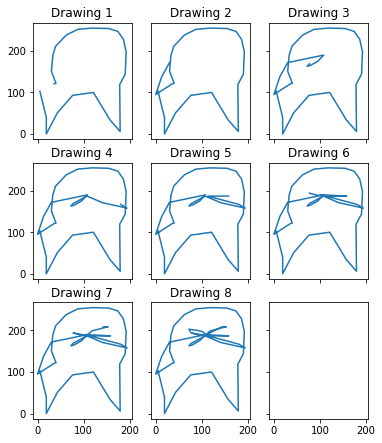

In [7]:
display_strokes(drawings[np.random.randint(0, len(drawings)-1)])

## Create a PyTorch DataLoader Using Drawings
Let's transform our dataset into a PyTorch DataLoader so we can begin training!

## Create Models

### Fully Convolutional Model

In [8]:
"""PyTorch neural network model for the listener agent.  This network
consists of a 1D CNN with max pooling to capture semantic features of from
the sequences of 2D points given to the listener, as well as adhere to
permutation invariance of the input sequences."""

# External package imports
import torch.nn as nn


# TODO: Insert dimensions
class ConvSketch(nn.Module):
    """Neural network object representing our listener network.  This network
    takes as input a sequence of 2D points corresponding to sampled
    components of the sketch uttered by the listener."""

    # Constructor method for class
    def __init__(self, in_channels=10, K_conv=5, K_mp=5, fc_neurons=500,
                 num_classes=10):
        # Inherit from superclass
        super(ListeNet, self).__init__()

        # Define parameters of network
        self.in_channels = in_channels
        self.K_conv = K_conv
        self.K_mp = K_mp

        # Feature detection
        self.conv1 = nn.Conv1d(self.in_channels, 1, kernel_size=self.K_conv)
        self.maxpool1 = nn.MaxPool1d(self.K_mp)

        # Multilayer Perceptron
        self.fc1 = nn.Linear(fc_neurons, fc_neurons // 4)
        self.fc2 = nn.Linear(fc_neurons // 4, fc_neurons // 16)

        # Classification layer
        self.SM = nn.Softmax(dim=num_classes)

    # Forward method for mapping input to output
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.maxpool1(x))
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return self.SM(x)


### RNN Model (Encoder of SketchNet VAE) - courtesy of [Alexis Jacq](https://github.com/alexis-jacq/Pytorch-Sketch-RNN)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size.cuda())
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat

### Simple RNN Model (Courtesy of [here](https://drive.google.com/drive/folders/1A0qUruvJbvHKZodW-k2vKbbF3BkYSfmN))

In [29]:
class ListeNet(nn.Module):

    def __init__(self, num_class=340):
        super(ListeNet,self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv1d(  2,  48, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm1d(48),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d( 48, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        self.lstm = nn.LSTM(128, 256, num_layers=1, dropout=0, bidirectional=True, batch_first=True)
        #True  #False

        self.logit = nn.Linear(256*2, num_class)



    def forward(self, x, length):
        #batch_size, T, dim = x.shape
        #batch_size, dim, _, T = x.shape
        x = x.permute(0,2,1)
        x = self.encoder1(x) #; print('e1',x.size())
        x = self.encoder2(x) #; print('e2',x.size())
        x = self.encoder3(x) #; print('e3',x.size())
        x = x.permute(0,2,1)

        if 1:
            xx = pack_padded_sequence(x, length, batch_first=True)
            yy, (h, c) = self.lstm (xx)
            y, _ = pad_packed_sequence(yy, batch_first=True)
        else:
            y, (h, c) = self.lstm (x)

        #z = y[:,-1,:]  #last one
        #z = h.view(batch_size,-1)  #hidden (one direction)
        z = h.permute(1,0,2).contiguous().view(batch_size,-1)  #hidden (bi direction)
        #z = torch.cat((h[0],h[1]),1)


        logit = self.logit(z)
        return logit


    def set_mode(self, mode, is_freeze_bn=False ):
        self.mode = mode
        if mode in ['eval', 'valid', 'test']:
            self.eval()
        elif mode in ['train']:
            self.train()
            if is_freeze_bn==True: ##freeze
                for m in self.modules():
                    if isinstance(m, BatchNorm2d):
                        m.eval()
                        m.weight.requires_grad = False
                        m.bias.requires_grad   = False



## Prepare Data for Training
### Training Hyperparameters

In [30]:
from torch import optim
import torch.nn.functional as F

TRAIN_TEST_SPLIT = 0.8
BATCH_SIZE = 1
NUM_CLASSES = 2
LISTENER = ListeNet(num_class=NUM_CLASSES)  # Model
LEARNING_RATE = 1e-3
OPT = optim.Adam(LISTENER.parameters(), lr=LEARNING_RATE)
LOSS = F.nll_loss  # Binary crossentropy

### Transform Sketch Lines to Images

In [31]:
def transform_to_images(drawings, out_shape=(256, 256), stroke_channels=20):
    output_images = []
    for drawing in drawings:
        A_img = np.zeros((256, 256, stroke_channels))
        for i in range(stroke_channels):  # Draw through all stroke channels
            A_img[:, :, i] = np.ones((256,256))  # TODO: Fix if using dense representation
            

In [32]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_sequence

# Import model
from models.listener import ListeNet

# Now let's create a DataLoader class
class QuickDrawDataset(Dataset):
    def __init__(self, data, labels):

        self.data = data
        self.tensors = []
        self.labels = labels
        self.custom_pad()

    def __len__(self):
        return len(self.data)
    
    def custom_pad(self):
        for i, drawing in enumerate(self.data):
            torch_drawing = (torch.t(pad_sequence([torch.tensor(stroke[0]) for stroke in drawing])).unsqueeze(1),
                                       torch.t(pad_sequence([torch.tensor(stroke[1]) for stroke in drawing])).unsqueeze(1))
            torch_drawing = torch.cat(torch_drawing, dim=1)
            self.tensors.append(torch_drawing)
            if i >= 99:
                print(pad_sequence([torch.tensor(stroke[0]) for stroke in drawing]).unsqueeze(1).size())
                break
            

    def __getitem__(self, index):
        return self.tensors[index], self.labels[index]

### Split Data into Training, Testing, Validation

In [33]:
# Find index of shuffled data to split
N = len(drawings)
indices = [i for i in range(N)]
np.random.shuffle(indices)

# Randomly shuffle drawings and labels
drawings = np.array(drawings)[indices]

# Now pre-process drawings
#drawings = transform_to_images(drawings)

classes = np.array(classes)[indices]

split = int(N * TRAIN_TEST_SPLIT)

# Now split data
train_data = drawings[:split]
train_labels = classes[:split]

val_data = drawings[split:split + N // 10]
val_labels = classes[split:split + N // 10]


test_data = drawings[split + N // 10:]
test_labels = classes[split + N // 10:]

# Now create Datasets - TODO: Format input arguments correctly
train_dataset = QuickDrawDataset(train_data, train_labels)
val_dataset = QuickDrawDataset(val_data, val_labels)
test_dataset = QuickDrawDataset(test_data, test_labels)

# Now create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

torch.Size([11, 1, 4])
torch.Size([11, 1, 5])
torch.Size([10, 1, 5])


### Test Dataset



[[33, 10, 8, 31, 33, 9, 0, 21, 63, 75, 80, 87, 89, 87, 69, 54, 47, 40, 31], [51, 54, 54, 49], [49, 49, 52, 53, 48], [58, 71, 73, 69], [73, 61], [61, 61], [56, 54, 54, 59, 62], [81, 120, 156, 164, 169, 174, 166, 144, 132, 127, 128, 165, 169, 167, 155, 143, 114, 96, 80, 42, 21, 13, 13, 43, 63, 69, 79, 79], [128, 145, 166], [112, 162]]


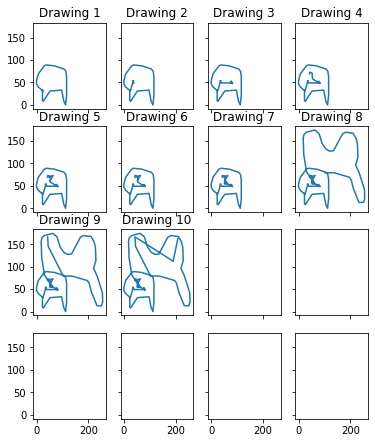

torch.Size([10, 2, 28])


In [34]:
drawing, label =  train_dataset.__getitem__(0)
print("\n")
print([stroke[1] for stroke in train_dataset.data[0]])
display_strokes(train_dataset.data[0])
print(drawing.size())
#print(drawing[0].size(), drawing[1].size())
#print(torch.cat((drawing[0], drawing[1]), dim=1).size())

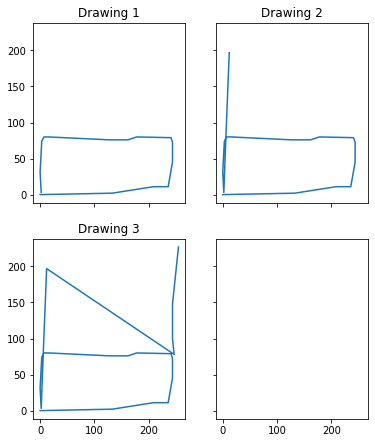

In [35]:
display_strokes(drawings[np.random.randint(0,high=len(drawings)-1)])

### Pooled LSTM with MLP
Let's keep things simple.

In [161]:
class LSTM(nn.Module):

    def __init__(self, num_strokes=20, stroke_length=20, lstm_dim_h=32, lstm_dim_out=32, num_class=2):
        
        # Superclass
        super(LSTM, self).__init__()
        
        # Parameters for LSTM
        self.N = num_strokes
        self.L = stroke_length
        self.num_class = num_class
        self.lstm_dim_h = lstm_dim_h
        
        # Input dimension
        self.input_dim = 2
        #print(input_dim)
        
        # LSTM for vector embeddings - rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.lstm = nn.LSTM(self.input_dim, self.lstm_dim_h)
        
        #nn.LSTM(input_size=input_dim, hidden_size=lstm_dim)
        
        """
        # Max pooling
        self.pool = nn.MaxPool1d(...)
        
        # Multilayer perceptron
        self.fc1 = nn.Linear(...)
        self.fc2 = nn.Linear(...)
        
        # Output logits
        self.SM  = nn.SoftMax(...)
        """

    def forward(self, x):
        x = x.long()
        lstm_output = np.zeros((self.N, self.lstm_dim_h))
        #print("LSTM output: {}".format(lstm_output))
        x = x.numpy()
        hidden = (torch.randn(self.N, 1, 1, self.lstm_dim_h))
        # LSTM
        for n in range(self.N):  # Iterate over all strokes
            xslice = torch.from_numpy(x[0,n,:,:self.L].T).long()
            xslice = xslice.unsqueeze(1).long()
            print("xslice {}".format(xslice.size()))
            lstm_output[n,:], hidden =  self.lstm(xslice, hidden)  # Call LSTM on each stroke
        x = torch.from_numpy(lstm_output)
        print(x.size())
        '''
        # Pooling
        x = self.pool(x)
        
        # MLP
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Classification
        classes = self.SM(x)
        return classes
        '''
        
        


## Training
Now that we've appropriately pre-processed our data, we can start training.

In [162]:
# Create dictionary for logging
history = {'loss_train': [], 'loss_val': []}

# Instantiate network
net = LSTM()

# Most generalizable format - predict based off of everything that's been drawn so far
for i, [data, label] in enumerate(train_dataloader):
    print(label)
    print("Data is: {}".format(type(data)))
    print(type(data.long()))
    predict = net(data.long())
    break

tensor([0])
Data is: <class 'torch.Tensor'>
<class 'torch.Tensor'>
xslice torch.Size([20, 1, 2])


TypeError: lstm() received an invalid combination of arguments - got (Tensor, Tensor, list, bool, int, float, bool, bool, bool), but expected one of:
 * (Tensor data, Tensor batch_sizes, tuple of Tensors hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional)
      didn't match because some of the arguments have invalid types: ([32;1mTensor[0m, [32;1mTensor[0m, [31;1mlist[0m, [31;1mbool[0m, [31;1mint[0m, [31;1mfloat[0m, [31;1mbool[0m, [32;1mbool[0m, [32;1mbool[0m)
 * (Tensor input, tuple of Tensors hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional, bool batch_first)
      didn't match because some of the arguments have invalid types: ([32;1mTensor[0m, [31;1mTensor[0m, [31;1mlist[0m, [32;1mbool[0m, [32;1mint[0m, [32;1mfloat[0m, [32;1mbool[0m, [32;1mbool[0m, [32;1mbool[0m)


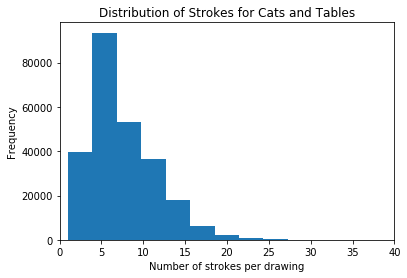

In [115]:
lengths = [len(drawing) for drawing in drawings]
plt.hist(lengths, bins=50)
plt.xlim(0, 40)
plt.xlabel("Number of strokes per drawing")
plt.ylabel("Frequency")
plt.title("Distribution of Strokes for Cats and Tables")
plt.show()

In [ ]:
lengths = list(itertools.chain.from_iterable([[len(stroke[0]) for stroke in drawing] for drawing in drawings]))
plt.hist(lengths, bins=1000)
plt.xlim(0, 40)
plt.xlabel("Number of coordinates per stroke")
plt.ylabel("Frequency")
plt.title("Distribution of Stroke Length for Cats and Tables")
plt.show()